In [15]:
import pandas as pd
df = pd.read_csv('water/temp/4.csv')
print(df.columns)
print('min,max,mean,std,skew,kurt')
for col in df.columns[3:12]:
    print(f'{col},{df[col].min():.3f},{df[col].max():.3f},{df[col].mean():.3f}'
          f',{df[col].std():.3f},{df[col].skew():.3f},{df[col].kurt():.3f}')



Index(['index', '监测时间', '站点名称', 'pH值', '总氮', '总磷', '氨氮', '水温', '浑浊度', '溶解氧',
       '电导率', '高锰酸盐指数', 'phFlag', 'TNFlag', 'TPFlag', 'NHFlag', 'temperFlag',
       'turbiFlag', 'doxygenFlag', 'conductFlag', 'permangaFlag'],
      dtype='object')
min,max,mean,std,skew,kurt
pH值,4.111,9.023,6.550,0.957,-0.164,-0.180
总氮,0.540,13.007,6.471,2.361,0.519,-0.144
总磷,0.045,1.172,0.447,0.271,0.815,-0.241
氨氮,0.003,5.963,1.752,1.480,0.949,-0.193
水温,12.042,36.550,26.201,4.808,-0.360,-0.739
浑浊度,0.000,1192.788,20.813,47.653,12.229,222.854
溶解氧,0.005,11.681,4.647,2.437,-0.209,-0.968
电导率,0.000,2639.052,315.000,282.111,2.211,9.733
高锰酸盐指数,0.123,11.167,5.092,2.407,0.863,-0.263


(100,)


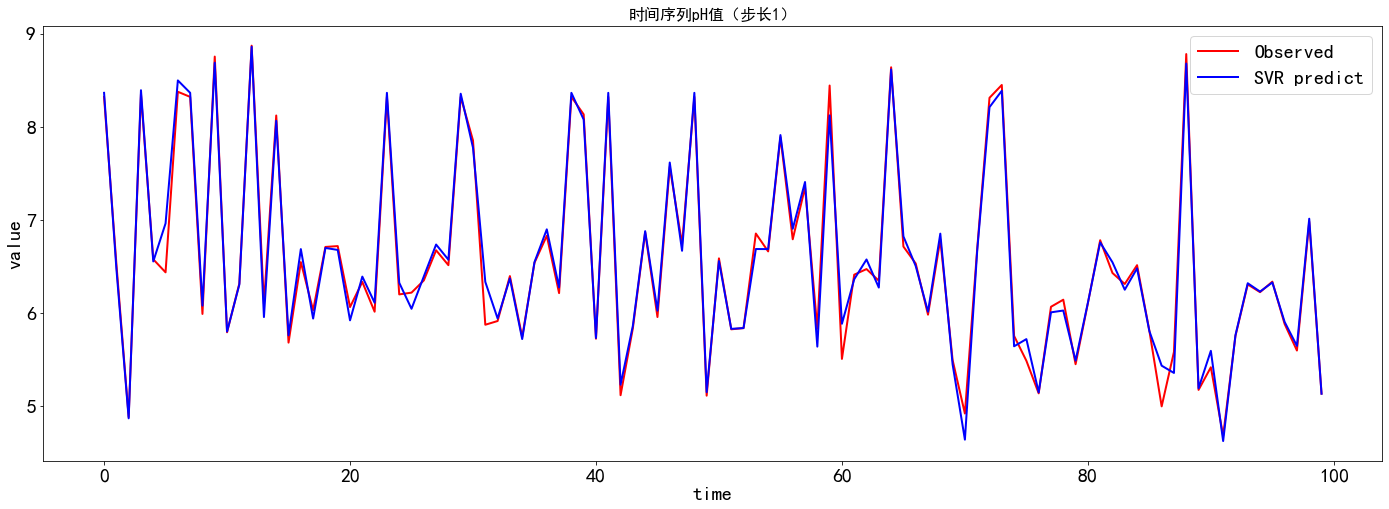

In [9]:
factors = ['pH值', '总氮', '总磷', '氨氮', '水温', '浑浊度', '溶解氧', '电导率', '高锰酸盐指数']
factors_en = ['pH', 'TN', 'TP', 'NH$_3$', '水温', '浑浊度', 'DO', '电导率', 'CODmn']

import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import os

place='shangban'

for fac in [0,1,2,3,6,8]:
    for step in range(3):
        y = np.load(f'data/output/{place}/y/BagSVR/BagSVR_fac{fac}_step{step}.npz')
        # seq_len = int(y['y_test'].size/10)
        seq_len = int(100)
        y_test = y['y_test'][:seq_len]
        y_pred = y['y_pred'][:seq_len]
        fig = plt.figure()
        ax = fig.add_subplot()

        print(y_test.shape)

        xx = np.array(range(y_test.size))

        plt.rcParams['font.sans-serif']=['SimHei']#显示中文标签
        plt.rcParams['figure.figsize']=(24,8)
        plt.rcParams.update({'font.size':20})
        plt.xlabel('time',fontsize=20)
        plt.ylabel('value',fontsize=20)


        ax.plot(xx,y_test, color='red', linewidth=2,label='Observed')
        ax.plot(xx,y_pred, color='blue', linewidth=2,label='SVR predict')
        plt.legend()

        # 保存
        save_root = f'data/output/shangban/figure/merge'
        if not os.path.exists(save_root):
            os.makedirs(save_root)
        plt.title(f'时间序列{factors[fac]}（步长{step+1}）',fontsize=16)
        # plt.text(0.05,0.8,f'y={k[0][0]:.3f}x+{b[0]:.3f}\nR2={r2:.3f}',
        #          fontsize=16,transform=ax.transAxes)
        plt.savefig(f'{save_root}/时间序列_{factors[fac]}.png'
                    ,dpi=960,bbox_inches = 'tight')
        plt.show()
        break
    break


In [6]:
import numpy as np
from sklearn import metrics
from water.SVR.data_generate import merge_site

for fac in [0, 1, 2, 3, 6, 8]:
    y = np.load(f'data/output/shangban/y/LSTM/{fac}/out.npz')
    y_test = merge_site(y['y_test'])
    y_pred = merge_site(y['y_pred'])

    print(f'scoring fac {fac}')
    for step in range(3):
        y_test_t = y_test[:,step]
        y_pred_t = y_pred[:,step]

        mae = metrics.mean_absolute_error(y_test_t, y_pred_t)
        mape = metrics.mean_absolute_percentage_error(y_test_t, y_pred_t)
        rmse = metrics.mean_squared_error(y_test_t, y_pred_t) ** 0.5
        rmspe = np_rmspe(y_test_t, y_pred_t)
        r2 = metrics.r2_score(y_test_t, y_pred_t)
        r = pearsonr(y_test_t, y_pred_t)[0]

        print(f'MAE:{mae:.3f},RMSE:{rmse:.3f},MAPE:{mape:.3f},R2:{r2:.3f}')
    break

scoring fac 0
MAE:0.141,RMSE:0.248,MAPE:0.022,R2:0.936
MAE:0.187,RMSE:0.321,MAPE:0.030,R2:0.892
MAE:0.225,RMSE:0.379,MAPE:0.036,R2:0.850


In [13]:
import water.SVR.data_generate as data_generate
import numpy as np
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy.stats import pearsonr
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

factors = ['pH值', '总氮', '总磷', '氨氮', '水温', '浑浊度', '溶解氧', '电导率', '高锰酸盐指数']

# param
fac_index = 0
model_name = 'RF'

place = 'shangban'


x_train, y_train, x_val, y_val, x_test, y_test = \
    data_generate.load_single_data(fac_index=fac_index, y_bool=False, y_length=3)

# maes=[]
# 每个步长分别预测

for step in range(3):
    # print(f'running {factors[fac_index]} for {step}th step')
    y_train_t = y_train[:,step]
    y_test_t = y_test[:,step]

    # bag_svr = BaggingRegressor(base_estimator=SVR(), n_estimators=32, random_state=0)
    # rf_regr = RandomForestRegressor(max_depth=32, random_state=0)
    regresstor = RandomForestRegressor(max_depth=2, random_state=0)
    lg_reg = LogisticRegression(random_state=0)
    regr = make_pipeline(StandardScaler(),lg_reg)
    # regressor = DecisionTreeRegressor(random_state=0)
    # regr = RandomForestRegressor(max_depth=2, random_state=0)
    # regr = AdaBoostRegressor(random_state=0, n_estimators=100)
    # BaggingRegressor(base_estimator=SVR(),n_estimators=10, random_state=0)
    
    lg_reg.fit(x_train, y_train_t)
    y_pred = regr.predict(x_test)
    # # 保存预测值
    save_root = f'data/output/{place}/y/{model_name}'
    if not os.path.exists(save_root):
        os.makedirs(save_root)
    np.savez_compressed(
        f'{save_root}/{model_name}_fac{fac_index}_step{step}.npz',
        y_pred=y_pred,
        y_test=y_test_t
    )
    
    mae = metrics.mean_absolute_error(y_test_t, y_pred)
    rmse = metrics.mean_squared_error(y_test_t, y_pred) ** 0.5
    r2 = metrics.r2_score(y_test_t, y_pred)
    mape = metrics.mean_absolute_percentage_error(y_test_t, y_pred)
    r = pearsonr(y_test_t, y_pred)[0]
    print(f'{factors[fac_index]}{step}th,{mae:.4f},{rmse:.4f},{r2:.4f},{mape:.4f},{r:.4f}')
    # break


ValueError: Unknown label type: 'continuous'

In [16]:
import water.common as water_common

print(water_common.model_full_names())

water_common.model_metric(1)


['SVR', 'RF', 'WaveNet', 'WaveNet-LSTM', 'WaveNet-MGCN', 'WaveNet-LSTM-MGCN']
pH值0th,0.1173,0.0184,0.2246,0.0352,0.9475,0.9734
pH值1th,0.1664,0.0265,0.3012,0.0494,0.9052,0.9514
pH值2th,0.1967,0.0315,0.3520,0.0581,0.8709,0.9333
总氮0th,0.4318,0.0733,0.7514,0.1527,0.9053,0.9515
总氮1th,0.5811,0.1109,0.9799,0.8283,0.8406,0.9170
总氮2th,0.6604,0.1208,1.0586,0.6495,0.8114,0.9009
总磷0th,0.0418,0.1109,0.0767,0.2448,0.9270,0.9630
总磷1th,0.0521,0.1357,0.0880,0.2144,0.9038,0.9512
总磷2th,0.0580,0.1495,0.0951,0.2307,0.8869,0.9423
氨氮0th,0.2832,0.3998,0.5109,1.9314,0.8879,0.9424
氨氮1th,0.3596,0.5126,0.5994,1.9103,0.8462,0.9200
氨氮2th,0.3820,0.6513,0.6118,2.6600,0.8387,0.9163
溶解氧0th,0.5507,0.6499,0.8582,6.1839,0.8876,0.9421
溶解氧1th,0.6947,1.5786,1.0513,28.8878,0.8307,0.9114
溶解氧2th,0.7776,2.1613,1.1680,28.9886,0.7883,0.8879
高锰酸盐指数0th,0.4257,0.1074,0.7533,0.3967,0.9074,0.9526
高锰酸盐指数1th,0.5061,0.1287,0.8582,0.7736,0.8806,0.9384
高锰酸盐指数2th,0.5654,0.1352,0.9476,0.3821,0.8562,0.9253
平均,0.3806,0.3946,0.6270,4.1432,0.8734,

In [ ]:
# from sklearn.ensemble import AdaBoostRegressor
# # ada_regr = AdaBoostRegressor(random_state=0, n_estimators=100,base_estimator=svm.svr())
# from sklearn.neighbors import KNeighborsRegressor
# neigh = KNeighborsRegressor(n_neighbors=2)


import water.water_sklearn as water_sklearn
from sklearn.svm import SVR
bag_svr = BaggingRegressor(base_estimator=SVR(), n_estimators=32, random_state=0)
water_sklearn.run('BagSVR',bag_svr)

